# Clustering sensitivity tests for *multi* in EOF space
Step of the codes :
- [Import modules](#modules)
- Define [settings](#settings)
- Download [pc_pred_optim](#download)
- Define [functions](#functions) for sensitivity tests (Inertia and Dunn index) and point removal at each iterations
- [Sensitivity test](#tests) with standard deviation estimate
- [Plot](#plot) the indexes 
- Illustration of [point removal technique](#removal)

# <a id='modules'>Import Modules</a>

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof
import random

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

## Clustering 
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedians import kmedians
from sklearn_extra.cluster import KMedoids


# tqdm + Remove warnings
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# <a id='settings'>Settings</a>

### Variables

In [2]:
variables = ['tas', 'pr', 'psl', 'SW', 'LW']
var_ceres = ['rsdt','rsut', 'rlut']
truncations = [18, 18, 8, 28, 22]
TITLE = 'Multi-variate'
ylabel = '$E_{tot}$'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/PPE/CNRM-CM6-1_PPE/'
path_files='/data/scratch/globc/peatier/HOME_files/PPE/CNRMppe_error_decomposition/files/'
path_file_npy = '/data/scratch/globc/peatier/HOME_files/PPE/ENSEMBLE2/files/npy/'
path_figures = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/Clustering/figures/'

# <a id='download'>Download PCs</a>

In [4]:
#path_files = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'

pc_PPE = {}
pc_obs = {}
pc_pred = {}
for var in variables :
    ## PPE
    path = path_files+'nc/'
    filename = 'pc_PPE_'+var+'.nc'
    pc_PPE_tmp = xr.open_mfdataset(path+filename,combine='by_coords')
    dims_dict = {'time' : 'members', 'mode' : 'modes'}
    pc_PPE[var] = pc_PPE_tmp.rename_dims(dims_dict)
    
    ## observations
    path = path_files+'nc/'
    filename = 'pc_obs_'+var+'.nc'
    pc_obs[var] = xr.open_mfdataset(path+filename,combine='by_coords')
    
    ## p1 - the first line of pc_PPE
    
    ## predictions
    path = path_files+'nc/'
    filename = 'pc_pred_'+var+'.nc'
    pc_pred_tmp = xr.open_mfdataset(path+filename,combine='by_coords')
    pc_pred[var] = pc_pred_tmp.rename({'__xarray_dataarray_variable__' : 'pcs'})

In [5]:
#path_files = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'
path = path_files+'nc/'
pc_optim = {}
for var in variables :
    filename = 'optim_pc_PPE_'+var+'_multi.nc'
    pc_optim[var] = xr.open_mfdataset(path+filename,combine='by_coords')

In [6]:
df_optim = pd.DataFrame()
cpt_trunc = 0
for var in variables :
    trunc = truncations[cpt_trunc]
    for i in range(1,trunc+1,1) :
        df_optim['EOF '+str(i)+' '+var] = pc_optim[var]['EOF '+str(i)].values
    cpt_trunc+=1
df_optim['LHS index'] = pc_optim[var]['LHS index'].values

In [7]:
df_optim

,EOF 1 tas,EOF 2 tas,EOF 3 tas,EOF 4 tas,EOF 5 tas,EOF 6 tas,EOF 7 tas,EOF 8 tas,EOF 9 tas,EOF 10 tas,...,EOF 14 LW,EOF 15 LW,EOF 16 LW,EOF 17 LW,EOF 18 LW,EOF 19 LW,EOF 20 LW,EOF 21 LW,EOF 22 LW,LHS index
0,0.053160,0.591416,0.177104,0.866376,-0.718467,-0.659540,-0.043037,0.556143,0.368302,-1.033655,...,-0.098080,-0.975946,-0.281429,-0.185335,0.176638,-0.306223,0.099916,0.654717,-1.133540,0
1,-1.011793,1.339372,1.565485,-0.114614,-2.109373,0.004198,0.100010,-0.431711,0.024609,0.297679,...,-0.379823,1.387612,-0.496919,1.171483,-0.344917,-1.007774,-0.146686,1.032652,0.005230,14
2,-0.384961,0.556234,-0.396392,-0.059524,-1.318948,0.235323,0.289680,-0.226521,-0.024458,-0.126000,...,0.251287,0.507676,-0.793967,-1.047735,-0.120428,0.425087,-0.646289,0.349680,0.252881,24
3,-0.270988,0.208586,0.606975,1.005541,-0.550034,0.227348,-0.026970,-0.256704,0.440614,-0.158742,...,-0.630755,-0.060103,0.575651,-0.300881,0.266193,1.178987,0.072353,0.537443,-0.899818,36
4,-0.299352,0.309064,2.783405,-0.125267,-0.715340,0.787181,0.565415,-1.050571,0.028596,0.408537,...,0.216559,1.040399,-0.862432,0.791998,-0.452841,0.318223,-0.636524,-0.220940,0.151882,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4984,0.466418,0.773169,-0.844275,-0.764109,-0.894000,-0.046908,-0.715592,-0.161486,0.356400,0.834269,...,0.022396,1.208086,0.564893,-0.204087,-0.464265,-1.084542,-0.313619,0.227772,1.008630,99929
4985,-0.627136,0.590900,1.234955,-0.434820,0.205836,0.752006,-0.547507,1.033733,-0.695691,0.887514,...,-0.482902,-0.237134,-0.166283,0.349432,0.410475,-0.424606,-0.472399,-0.800697,0.719077,99933
4986,0.203675,0.899939,0.128886,0.561057,0.135676,-0.040235,0.744816,1.110649,-0.499779,-0.410537,...,0.622922,0.191361,-1.198509,1.687077,-0.203311,-1.362365,-0.125646,-0.036607,0.229306,99962
4987,-0.938848,0.741590,1.616601,-0.705452,0.071571,0.880203,-0.589251,1.118385,-0.486073,1.071030,...,0.564887,-0.021714,-1.196097,0.777178,0.084771,-0.312025,-0.859730,-0.545371,0.771119,99976


# Clustering analysis

## <a id='functions'>Functions sensitivity</a>

In [8]:
def distances_per_cluster(kmedoids, tmp_r) :
    dist = kmedoids.transform(tmp_r)
    df_dist = pd.DataFrame(dist)
    std = df_dist.std()
    mean = df_dist.mean()
    #df_dist.plot.hist(bins=30, alpha=0.5)
    
    return(df_dist)
    
def distances_mean(df_dist, perc1_nb, perc2_nb, max_model_nb) :
    df_dist_mean = (df_dist[0]+df_dist[1])/2
    std_m = df_dist_mean.std()
    mean_m = df_dist_mean.mean()
    perc1 = np.percentile(df_dist_mean, perc1_nb, axis=0) 
    perc2 = np.percentile(df_dist_mean, perc2_nb, axis=0) 
    median = np.percentile(df_dist_mean, 50, axis=0) 
    return(df_dist_mean, perc1, perc2)

In [9]:
def Clustering_sensitivity_tests(tmp_r, nb_clusters_max, step) :
    cluster_list = []
    centers_list = []
    inertia_list = []
    inter_cluster_list = []
    intra_cluster_list = []
    Dunn_list = []

    for n_clusters in range(2,nb_clusters_max,step) :
        #print(n_clusters)
    
        kmedoids = KMedoids(n_clusters).fit(tmp_r)
        #kmean = KMeans(n_clusters).fit(tmp_r)

        cluster = kmedoids.labels_
        centers = kmedoids.cluster_centers_
        inert = kmedoids.inertia_
    
        from scipy.spatial import distance
        dist = distance.cdist(centers, centers, 'euclidean')
        df_dist = pd.DataFrame(dist)
        df_dist.replace(0, np.nan, inplace=True)
        inter_cluster_min = df_dist.min().min()
    
        dist = kmedoids.transform(tmp_r)
        intra_cluster_max = dist.max()
    
        Dunn = inter_cluster_min/intra_cluster_max
    
        cluster_list.append(cluster)
        centers_list.append(centers)
        inertia_list.append(inert)
    
        inter_cluster_list.append(inter_cluster_min)
        intra_cluster_list.append(intra_cluster_max)
        Dunn_list.append(Dunn)
    
        ## -------------------- Pour enlever des points au fur et à mesure ----------
        ## Compute distances, mean and percentiles  
        df_dist = distances_per_cluster(kmedoids, tmp_r)
        perc1_nb = 4
        perc2_nb = 96
        max_model_nb = 3000
        df_dist_mean, perc1, perc2 = distances_mean(df_dist, perc1_nb, perc2_nb, max_model_nb)
    
        ## Remove 20% of the further points
        cpt = 0
        list_remove = []
        for i in df_dist_mean :
            if i < perc1 or i > perc2 :
                list_remove.append(cpt)
                cpt+=1
            else :
                cpt+=1 
        df_short = tmp_r.drop(list_remove)
    
        ## Prepare the next iteration 
        tmp_r = df_short.reset_index().drop('index', axis=1)
    
    return(inertia_list, Dunn_list, tmp_r)

## <a id='tests'>Sensitivity tests</a>

In [10]:
inertia_list_mean = []
Dunn_list_mean = []
nb_clusters_max = 50
nb_bootstrap = 10
step = 1

for cpt in tqdm(range(0,nb_bootstrap,1)) :
    
    #print('cpt = '+str(cpt))
    
    ## Create the initial matrix to cluster 
    list_index = []
    cpt_trunc = 0
    trunc_cluster = 5
    for var in variables :
        trunc = truncations[cpt_trunc]
        for i in range(1,trunc_cluster+1,1) :
            tmp = 'EOF '+str(i)+' '+var
            list_index.append(tmp)
        cpt_trunc+=1
    tmp = df_optim[list_index].transpose().reset_index().drop(['index'], axis=1)
    tmp_r = tmp.transpose()
    
    ## Sensitivity test
    inertia_list_mean_tmp, Dunn_list_mean_tmp, tmp_r = Clustering_sensitivity_tests(tmp_r, nb_clusters_max, step)
    inertia_list_mean.append(inertia_list_mean_tmp)
    Dunn_list_mean.append(Dunn_list_mean_tmp)

100%|██████████| 10/10 [00:37<00:00,  3.80s/it]


In [15]:
xr_inertia_list_mean = xr.DataArray(inertia_list_mean).mean('dim_0')
xr_inertia_list_std = xr.DataArray(Dunn_list_mean).mean('dim_0')
xr_Dunn_list_mean = xr.DataArray(Dunn_list_mean).mean('dim_0')
xr_Dunn_list_std = xr.DataArray(Dunn_list_mean).std('dim_0')

In [16]:
tmp_r

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.093874,1.676259,-0.146659,-0.939808,-0.816423,1.142276,-0.709310,-1.413830,0.781013,0.833960,...,1.150417,-0.357619,1.625791,0.875446,0.207323,0.203433,0.454306,-1.487765,-0.800638,-0.613875
1,-0.477951,0.637273,1.031205,-0.999204,-0.984757,1.154765,-0.963445,-1.081380,-0.003132,-0.983867,...,0.793747,1.108183,-0.367083,0.838611,-0.748184,0.601552,0.539938,-1.530617,-0.401451,0.327332
2,1.012699,0.702730,0.523563,-0.330496,-0.977175,1.024900,-0.020446,-1.187718,-0.441207,0.937521,...,0.940066,-0.226738,0.861100,1.320160,-0.779468,0.048189,1.229289,-1.185400,-0.626258,-0.543271
3,0.005512,-0.139926,0.308216,-0.231471,-0.370503,0.848168,0.285644,-0.301210,-0.464786,-0.332759,...,0.050033,-0.397499,-0.582803,1.239733,-0.713136,-0.755215,0.672785,-0.705219,-0.424754,-0.238276
4,-0.278316,1.429857,1.839450,0.380128,0.524999,0.550086,-0.546540,-0.696903,0.089577,-0.504435,...,0.265427,0.576470,0.097394,0.672472,-0.196370,-0.458440,0.876877,-0.815137,-0.221506,0.095469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,-0.444696,0.350164,0.453363,-0.652441,-1.170191,0.289495,-0.144778,0.099707,0.499418,1.522848,...,0.034058,0.289717,0.628293,1.115644,0.299614,-0.805410,1.136024,-1.116156,0.736091,-0.273509
75,0.602433,0.562537,1.735732,0.319252,-1.635894,0.986039,-1.087241,-0.518628,0.190815,0.300804,...,1.526335,0.259737,0.453687,1.339934,0.707811,-0.023889,0.892811,-1.838320,0.522145,0.069466
76,0.367031,1.019345,0.044156,0.555932,-0.700670,0.415197,-0.626148,-1.028001,-0.426188,-0.227437,...,0.097921,1.482141,1.114647,-0.147381,-0.063322,-0.089621,-0.262748,-0.872001,-1.165320,-0.833143
77,-0.130145,1.250208,2.201812,0.042879,-0.576824,1.161449,-0.828870,-0.843339,0.472277,-0.062682,...,1.291278,0.278290,-0.311602,1.447931,0.142168,-0.619109,0.764503,-1.873669,0.553961,-0.260276


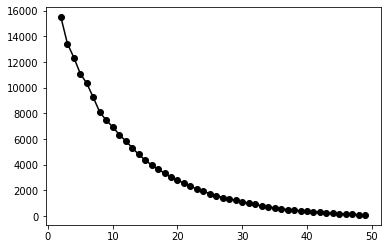

In [17]:
plot(range(2,50,1), xr_inertia_list_mean, '-o', color='black', linewidth=1.5)

In [18]:
dict_index = {}
cpt = 0
for ind in list_index :
    dict_index[cpt] = ind
    cpt +=1 
#dict_index

In [19]:
tmp_r = tmp_r.rename(dict_index, axis=1)
xr_tmp_r = tmp_r.to_xarray()
## Save file
filename = 'df_optim_reducted_after_sensitivity_test_multi_kmedian.nc'
xr_tmp_r.to_netcdf(path_files+'nc/'+filename)

## <a id='plot'>Plot indexes</a>

In [20]:
inertia_list_mean_new = []
inertia_list_stdplus_new = []
inertia_list_stdmoins_new = []

Dunn_list_mean_new = []
Dunn_list_stdplus_new = []
Dunn_list_stdmoins_new = []

for i in range(0,48,2) : 
    inert_tmp_mean = xr_inertia_list_mean[i]
    inertia_list_mean_new.append(inert_tmp_mean)
    Dunn_tmp_mean = xr_Dunn_list_mean[i]
    Dunn_list_mean_new.append(Dunn_tmp_mean)
    
    tmp = xr_inertia_list_std[i]
    inertia_list_stdplus_new.append((inert_tmp_mean+tmp))
    inertia_list_stdmoins_new.append((inert_tmp_mean-tmp))
    
    tmp = xr_Dunn_list_std[i]
    Dunn_list_stdplus_new.append((Dunn_tmp_mean+tmp))
    Dunn_list_stdmoins_new.append((Dunn_tmp_mean-tmp))

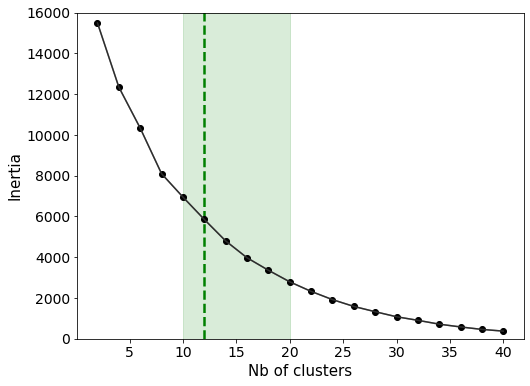

In [26]:
plt.figure(figsize=(8,6))
plot(range(2,42,2), inertia_list_mean_new[0:20], '-o', color='black', linewidth=1.5)
plot(range(2,42,2), inertia_list_stdplus_new[0:20], '-', 
     color='grey', linewidth=1.5, alpha=0.2)
plot(range(2,42,2), inertia_list_stdmoins_new[0:20], '-', 
     color='grey', linewidth=1.5, alpha=0.2)
plt.vlines(12, -5, 800000, linestyle = '--', color='green', linewidth=2.5)
#plt.vlines(7, 0, 250000, linestyle = '-', color='green', linewidth=1.5)
#plt.vlines(18, 0, 250000, linestyle = '-', color='green', linewidth=1.5)
ax = plt.gca()
ax.axvspan(10, 20, alpha=0.15, color='green')
plt.ylim(0,16000)
plt.ylabel('Inertia', fontsize=15)
plt.xlabel('Nb of clusters', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
filename = 'Sensitivity_test_inertia_multi_kmedian.png'
plt.savefig(path_figures+filename, bbox_inches='tight' )
plt.show()

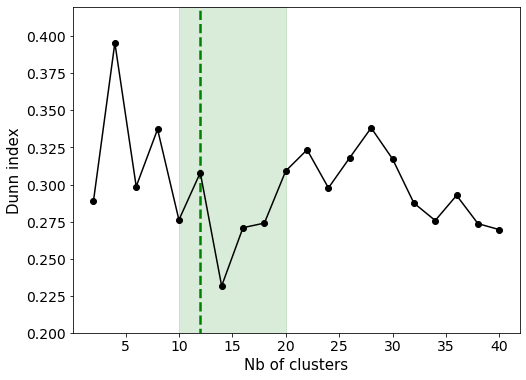

In [27]:
plt.figure(figsize=(8,6))
plot(range(2,42,2), Dunn_list_mean_new[0:20], '-o', color='black', linewidth=1.5)
#plot(range(2,42,2), Dunn_list_stdplus_new[0:20], '-', color='grey', linewidth=1.5, alpha=0.5)
#plot(range(2,42,2), Dunn_list_stdmoins_new[0:20], '-', color='grey', linewidth=1.5, alpha=0.5)

ax = plt.gca()
ax.axvspan(10, 20, alpha=0.15, color='green')
plt.vlines(12, 0, 0.55, linestyle = '--', color='green', linewidth=2.5)

plt.ylabel('Dunn index', fontsize=15)
plt.xlabel('Nb of clusters', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(0.20,0.42)
#plt.xlim(0,40)

filename = 'Sensitivity_test_Dunn_multi_kmedian.png'
plt.savefig(path_figures+filename, bbox_inches='tight' )

plt.show()